# Understanding college debt
I want to see what types of universities have students in debt.  We will be using the college scorecard API from data.gov.  I am interested in a number of variables, these are admissions rate, tuition, median household income, student size, etc.

It seems that the UC office of president <a href="http://www.ucop.edu/institutional-research-academic-planning/_files/College%20Scorecard%20Brief.pdf">claims that the UC schools are a good deal</a> based on data from the college scorecard.

You should go begin by getting an <a href="https://api.data.gov/signup/">API key for data.gov</a>.  There are many data.gov APIs that you can use this key for and they have fairly relaxed limits on the number of requests.

The documentation for the API can be found here...<br>
https://github.com/RTICWDT/open-data-maker/blob/master/API.md<br>
https://collegescorecard.ed.gov/data/

Let's import some packages.

In [3]:
from urllib2 import Request, urlopen
from urlparse import urlparse, urlunparse
import requests, requests_cache
import pandas as pd
import json
from matplotlib import pyplot as plt
plt.style.use('ggplot')
from keys import *
%matplotlib inline
requests_cache.install_cache('coll_cache')

Here are some variable names that we will be interested in.

In [4]:
varnames = """id
school.name
school.degrees_awarded.predominant
2014.admissions.admission_rate.overall
2014.cost.tuition.in_state
2014.cost.tuition.out_of_state
2014.aid.median_debt.completers.overall
2014.aid.median_debt.noncompleters
2005.student.demographics.median_hh_income
2005.student.demographics.poverty_rate
2014.aid.federal_loan_rate
2014.aid.pell_grant_rate
2014.student.size"""
fieldnames = varnames.split("\n")

__Exercise (1)__ I would like to make a complicated query from the API.  An example query from the API is 

<pre>https://api.data.gov/ed/collegescorecard/v1/schools.json?school.degrees_awarded.predominant=3&_fields=school.name,
2014.aid.pell_grant_rate&_sort=2014.student.size:desc&_page=1
&_per_page=100&api_key=YOURKEY
</pre>

Which can be parsed as  
1. the base url: https://api.data.gov/ed/collegescorecard/v1/schools.json, 
2. a filter of school.degrees_awarded.predominant=3, 
3. return the fields school.name,2014.aid.pell_grant_rate, 
4. sort by 2014.student.size in descending order, 
5. return 1 page of 100 entries, 
6. and use your api key

You can find a more complete description: https://github.com/RTICWDT/open-data-maker/blob/master/API.md

Fill in the following def that fits the following docstring, and gives the shown output.
<pre>
def query_url(key,fieldnames,filterstring,sortvar,numpages):
    """
    This takes all of the necessary parameters to form a query 
    to college scorecard
    Input: key (data.gov API key, string), fieldnames (list of variable 
      names), filterstring (string for filtering), sortvar (variable to 
      sort with by descending), numpages (number of pages to return)
    Output: url (string)
    """


query_url(key,fieldnames,'school.degrees_awarded.predominant=3',
  '2014.student.size',2)

https://api.data.gov/ed/collegescorecard/v1/schools.json?school.degrees_awarded.predominant=3&_fields=id,school.name,school.degrees_awarded.predominant,school.degree_urbanization,2014.admissions.admission_rate.overall,2014.cost.tuition.in_state,2014.cost.tuition.out_of_state,2014.aid.median_debt.completers.overall,2014.aid.median_debt.noncompleters,2005.student.demographics.median_hh_income,2005.student.demographics.poverty_rate,2014.aid.federal_loan_rate,2014.aid.pell_grant_rate,2014.student.size&_page=2&_per_page=100&_sort=2014.student.size:desc&api_key=YOURKEYHERE
</pre>

Try to reproduce the above behavior.

In [54]:
def query_url(key,fieldnames,condvar,condval,sortvar,numpage,return_request = False):
    """
    This takes all of the necessary parameters to form a query 
    to college scorecard
    Input: key (data.gov API key, string), fieldnames (list of variable 
      names), filterstring (string for filtering), sortvar (variable to  
      sort with by descending), numpages (number of pages to return)
    Output: url (string)
    """
    urlbase = "https://api.data.gov/ed/collegescorecard/v1/schools.json"
    params = {condvar : condval}
    params.update({"_page":numpage, "_per_page":100})
    params.update({"_fields":",".join(fieldnames)})
    params.update({"_sort":sortvar+":desc","api_key":key})
    if return_request:
        return requests.get(urlbase,params=params)
    return urlbase + "?" + "&".join("{}={}".format(a,b) for a,b in params.items())

In [55]:
fieldnames

['id',
 'school.name',
 'school.degrees_awarded.predominant',
 '2014.admissions.admission_rate.overall',
 '2014.cost.tuition.in_state',
 '2014.cost.tuition.out_of_state',
 '2014.aid.median_debt.completers.overall',
 '2014.aid.median_debt.noncompleters',
 '2005.student.demographics.median_hh_income',
 '2005.student.demographics.poverty_rate',
 '2014.aid.federal_loan_rate',
 '2014.aid.pell_grant_rate',
 '2014.student.size']

In [56]:
query_url("YOURKEYHERE",fieldnames,'school.degrees_awarded.predominant',3,'2014.student.size',2)

'https://api.data.gov/ed/collegescorecard/v1/schools.json?api_key=YOURKEYHERE&school.degrees_awarded.predominant=3&_sort=2014.student.size:desc&_per_page=100&_fields=id,school.name,school.degrees_awarded.predominant,2014.admissions.admission_rate.overall,2014.cost.tuition.in_state,2014.cost.tuition.out_of_state,2014.aid.median_debt.completers.overall,2014.aid.median_debt.noncompleters,2005.student.demographics.median_hh_income,2005.student.demographics.poverty_rate,2014.aid.federal_loan_rate,2014.aid.pell_grant_rate,2014.student.size&_page=2'

__Exercise (2)__ Make the query using Request and load the results into a DataFrame that makes sense.

In [8]:
#Option 1: using urllib2
collurl = query_url(govkey,fieldnames,'school.degrees_awarded.predominant',3,'2014.student.size',2)
collreq = Request(collurl)
collf = urlopen(collreq)
college_json = json.loads(collf.read())

In [57]:
#Option 2: using requests
collreq = query_url(govkey,fieldnames,'school.degrees_awarded.predominant',3,'2014.student.size',1,return_request=True)
college_json = collreq.json()
print collreq.json()
coll_df = pd.DataFrame(college_json['results'])

{u'results': [{u'2014.admissions.admission_rate.overall': 0.594, u'2014.aid.pell_grant_rate': 0.5699, u'2014.student.size': 20128, u'2014.aid.median_debt.completers.overall': 15993.5, u'2005.student.demographics.poverty_rate': 16.0699996948242, u'2005.student.demographics.median_hh_income': 53295, u'school.degrees_awarded.predominant': 3, u'2014.cost.tuition.out_of_state': 17459, u'2014.cost.tuition.in_state': 6299, u'2014.aid.median_debt.noncompleters': 10809.0, u'2014.aid.federal_loan_rate': 0.3316, u'school.name': u'California State University-Fresno', u'id': 110556}, {u'2014.admissions.admission_rate.overall': 0.6989, u'2014.aid.pell_grant_rate': 0.1989, u'2014.student.size': 19979, u'2014.aid.median_debt.completers.overall': 21500.0, u'2005.student.demographics.poverty_rate': 5.94000005722045, u'2005.student.demographics.median_hh_income': 60976, u'school.degrees_awarded.predominant': 3, u'2014.cost.tuition.out_of_state': 22090, u'2014.cost.tuition.in_state': 8170, u'2014.aid.medi

In [58]:
def get_coll_page(page):
    collreq = query_url(govkey,fieldnames,'school.degrees_awarded.predominant',3,'2014.student.size',page,return_request=True)
    college_json = collreq.json()
    coll_df = pd.DataFrame(college_json['results'])
    return coll_df

In [59]:
coll_df = get_coll_page(1)

In [60]:
coll_df = coll_df.append(get_coll_page(2))

In [61]:
coll_df.head()

,2005.student.demographics.median_hh_income,2005.student.demographics.poverty_rate,2014.admissions.admission_rate.overall,2014.aid.federal_loan_rate,2014.aid.median_debt.completers.overall,2014.aid.median_debt.noncompleters,2014.aid.pell_grant_rate,2014.cost.tuition.in_state,2014.cost.tuition.out_of_state,2014.student.size,id,school.degrees_awarded.predominant,school.name
0,53295.0,16.07,0.5940,0.3316,15993.5,10809.0,0.5699,6299,17459,20128,110556,3,California State University-Fresno
1,60976.0,5.94,0.6989,0.3856,21500.0,7500.0,0.1989,8170,22090,19979,181464,3,University of Nebraska-Lincoln
2,60340.0,7.85,0.7206,0.5668,21743.0,9250.0,0.4473,7876,24124,19928,220978,3,Middle Tennessee State University
3,63797.0,7.60,0.8189,0.5588,23178.5,12500.0,0.3500,8970,25140,19842,232982,3,Old Dominion University
4,59909.0,6.27,0.9493,0.4922,22236.0,9500.0,0.2447,9034,22624,19727,155399,3,Kansas State University


In [62]:
coll_df.shape

(200, 13)

In [63]:
coll_df = coll_df.set_index("id")

In [64]:
del coll_df['school.degrees_awarded.predominant']

In [65]:
coll_df.columns

Index([u'2005.student.demographics.median_hh_income',
       u'2005.student.demographics.poverty_rate',
       u'2014.admissions.admission_rate.overall',
       u'2014.aid.federal_loan_rate',
       u'2014.aid.median_debt.completers.overall',
       u'2014.aid.median_debt.noncompleters', u'2014.aid.pell_grant_rate',
       u'2014.cost.tuition.in_state', u'2014.cost.tuition.out_of_state',
       u'2014.student.size', u'school.name'],
      dtype='object')

In [66]:
coll_df = coll_df.rename(columns={
    u'2005.student.demographics.median_hh_income':"income",
    u'2005.student.demographics.poverty_rate':"poverty",
    u'2014.admissions.admission_rate.overall':"adm. rate",
    u'2014.aid.federal_loan_rate':"loan rate",
    u'2014.aid.median_debt.completers.overall':"debt comp.",
    u'2014.aid.median_debt.noncompleters':"debt nonc.", u'2014.aid.pell_grant_rate':"pell rate",
    u'2014.cost.tuition.in_state':"IS tuit.", u'2014.cost.tuition.out_of_state':"OS tuit.",
    u'2014.student.size':"size", u'school.name':"name"
    })

__Exercise (3)__ Produce scatterplots to demonstrate the associations between student debt (for 'completers') and median household income, pell grant rates, student poverty rate, tuition, and federal loan rate.  Do you have an explanation for the associations that you are seeing?  Are there some surprising associations.

In [67]:
from pandas.tools.plotting import scatter_matrix

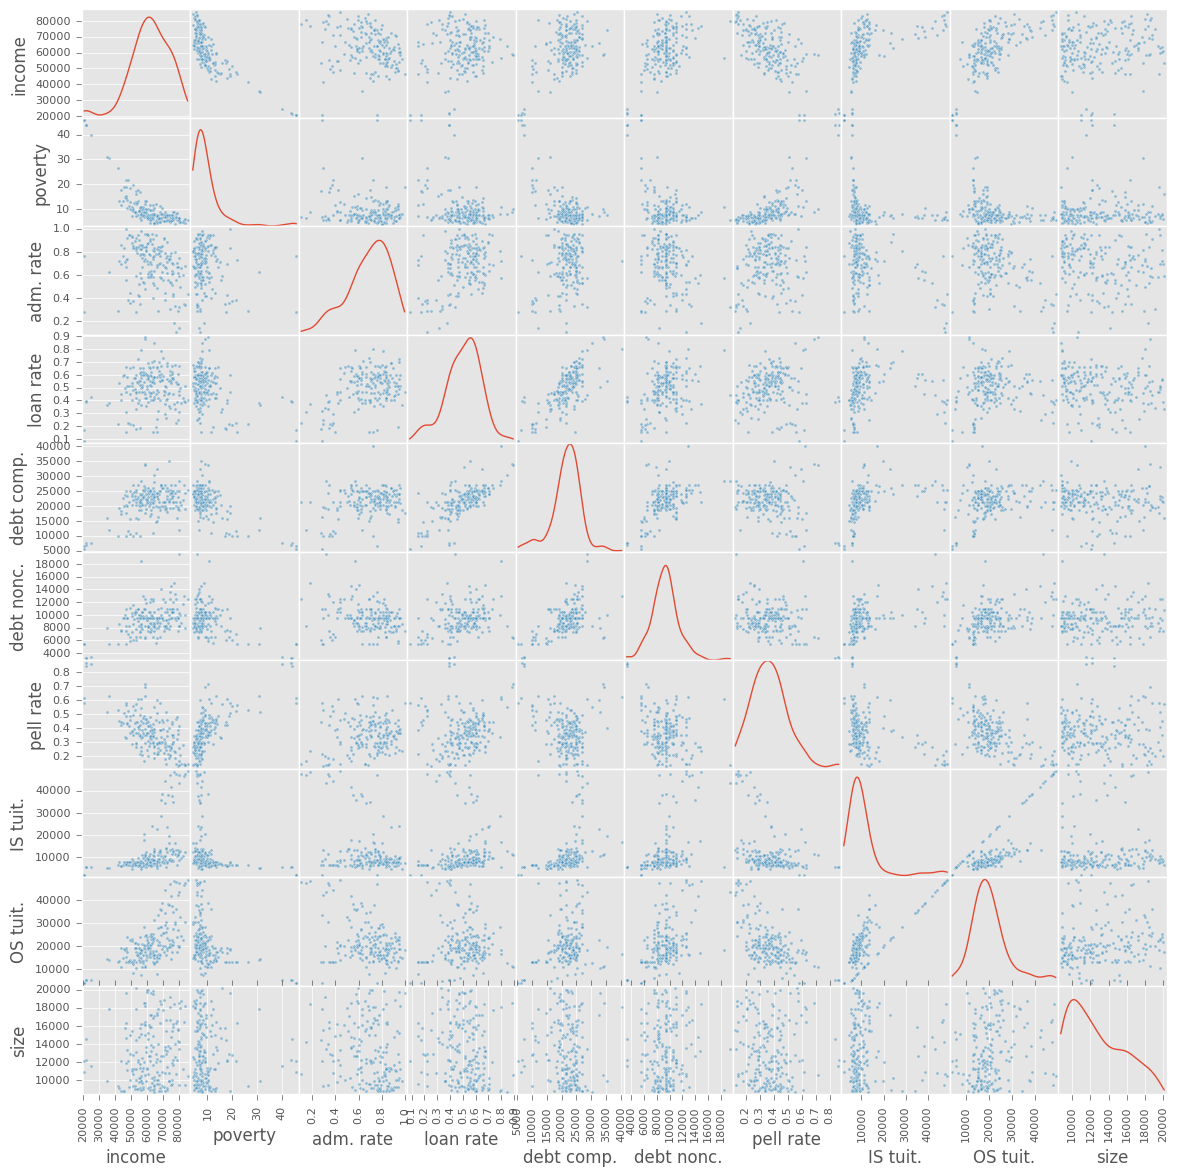

In [68]:
_ = scatter_matrix(coll_df,figsize=(14,14),diagonal='kde')

There may be meaningful associations between poverty rate and income, income and pell rate, income and debt comp, and loan rate and debt comp.

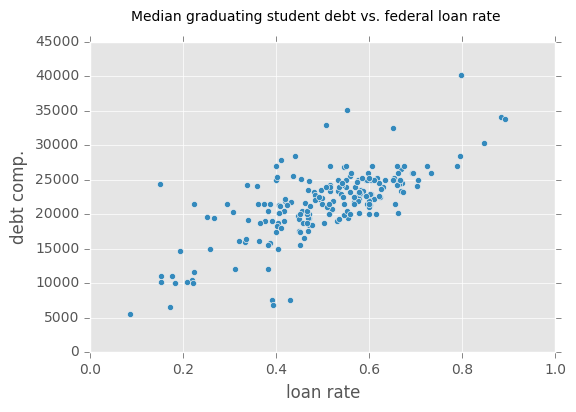

In [69]:
_ = coll_df.plot('loan rate','debt comp.',kind='scatter')
_ = plt.suptitle('Median graduating student debt vs. federal loan rate')

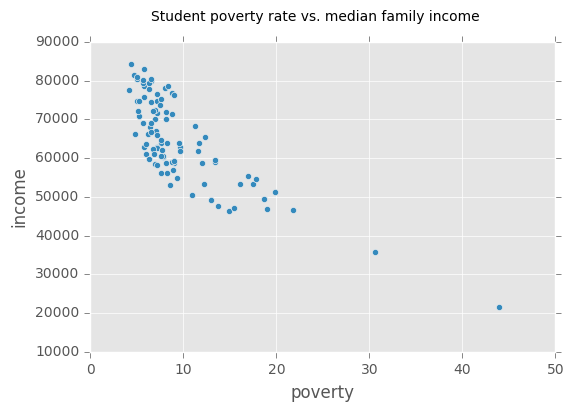

In [48]:
_ = coll_df.plot('poverty','income',kind='scatter')
_ = plt.suptitle('Student poverty rate vs. median family income')

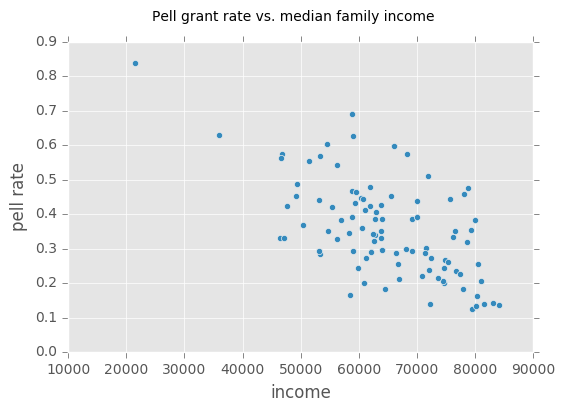

In [49]:
_ = coll_df.plot('income','pell rate',kind='scatter')
_ = plt.suptitle('Pell grant rate vs. median family income')

The above plots are consistent with expected trends. First, the Pell grant rate is higher for universities with lower family incomes, because the Pell grants are awarded to lower-income students.  The universities with higher loan rates also have higher median debt.  Also, income and poverty rate are obviously negatively correlated.

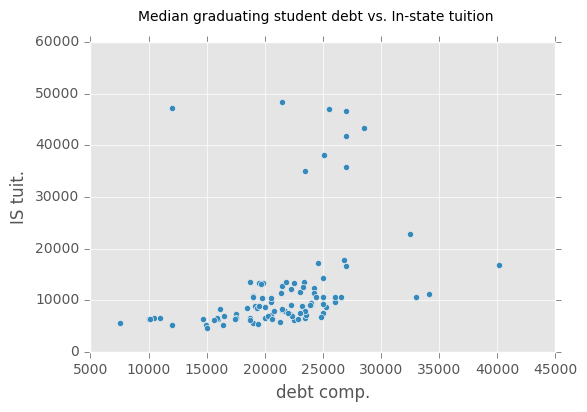

In [50]:
_ = coll_df.plot('debt comp.','IS tuit.',kind='scatter')
_ = plt.suptitle('Median graduating student debt vs. In-state tuition')

There is a small trend toward larger debt for higher tuitions, but this is not very influential relative to other variables.

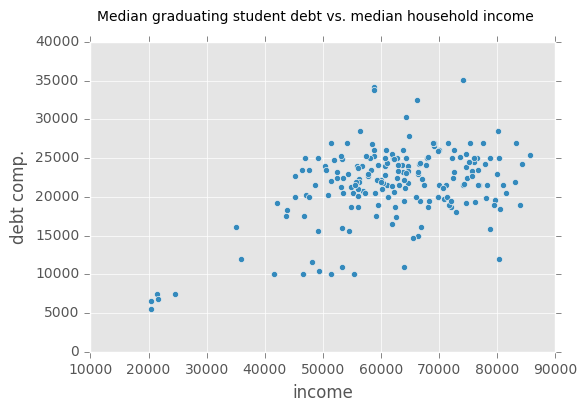

In [70]:
_ = coll_df.plot('income','debt comp.',kind='scatter')
_ = plt.suptitle('Median graduating student debt vs. median household income')

The above plot shows a surprising trend: as household income increases the debt increases as well.  This is inconsistent with the idea that families with low income will incur more debt because they are inable to pay tuition without taking loans.

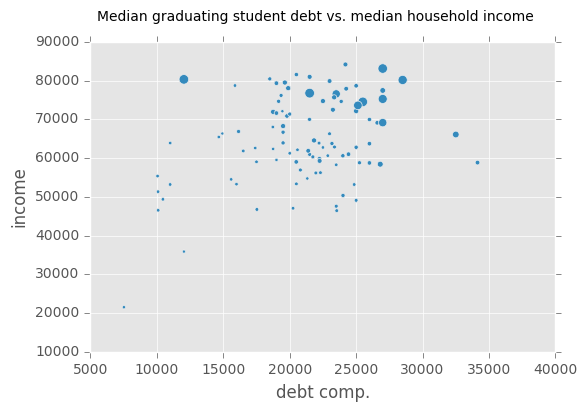

In [52]:
_ = coll_df.plot('debt comp.','income',s=coll_df['IS tuit.']/1000,kind='scatter')
_ = plt.suptitle('Median graduating student debt vs. median household income')

In the above plot, the area of the points are proportional to the In-state tuition.  The tuition of the school is a possible confounder when comparing income to debt, but this plot indicates that the tuition does not explain much of the trend between income and debt.  Also, we have seen previously that there is not a strong association between the tuition and debt.

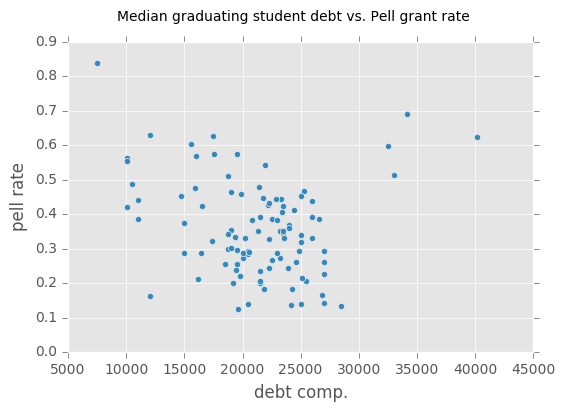

In [53]:
_ = coll_df.plot('debt comp.','pell rate',kind='scatter')
_ = plt.suptitle('Median graduating student debt vs. Pell grant rate')

Finally, another possible confounder is the pell grant rate.  Specifically, that lower income students are recieving pell grants (which has been previously demonstrated).  This plot demonstrates that there does not seem to be a strong association between pell rate and student debt.

## Conclusion
When explaining median debt for graduating students, median household income is observed to have a strong association.  This cannot be explained empirically by larger tuitions or a decreased rate of Pell grants.  There are several possible explanations for this unexplained trend.
1. There is some unexplained mechanism by which the higher income students tend to accept more debt (perhaps due to higher credit scores or expected future earnings)
2. The nature of universities and degree programs that higher/lower income students attempt influences their debt.
3. The sample is not representative of the population of universities, and the association is due to sampling bias.

Further studies into the degree programs through the API, and taking a larger and more inclusive sample can address 2. and 3., 1. is much more difficult to validate.